## Extracting data from sTD-xTB outputs

The output files are assumed to be `./std_xtb_run/train-*-std.out`, * being the entry number in csv. The excitation ($E_{max}$) corresponding to the experimental $E_{max}$ has to be extracted from the sTD-xTB output files. We use a simple procedure—first, all peaks in the range $( E_{max}-0.57$, $ E_{max}+0.57)$ are extracted, then, the peak with the highest oscillator strength among those peaks is selected. The numbers used in constructing the range are estimates from the benchmark. (In case there is no peak in the range, then the first excitation is selected.)

After data extraction, all entries where the calculated and experimental values differ by more than 1.0 eV are discarded. This is because such high errors can't be corrected by machine learning.

In [1]:
# data reading and processing
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# for MAE values
from sklearn.metrics import mean_absolute_error

In [2]:
def get_xtb_lambda(filename,range_min,range_max):
    """ Given a range of wavelengths, it extracts higest peak in eV from sTD-xTB output """
    header_found=False
    lambda_list = [] # lambda in eV here!!!
    foscs_list = []
    with open(filename,'r') as fh:
        for line in fh:
            if not header_found:
                if line.find('state    eV      nm       fL         Rv')!=-1:
                    header_found=True
            elif line.strip()!='':
                data = line.strip().split()
                lambda_list.append(float(data[1])) ## get eV
                foscs_list.append(float(data[3])) ## get fL
            else:
                break
    lambda_list_new = np.array(lambda_list) # convert to numpy array
    foscs_list_new = np.array(foscs_list)
    my_filter = (lambda_list_new>range_min) & (lambda_list_new<range_max)
    foscs_list_new = foscs_list_new[my_filter]
    lambda_list_new = lambda_list_new[my_filter]
    if len(lambda_list_new)!=0:
        return lambda_list_new[np.argmax(foscs_list_new)]
    else: # unusual case, return the first excitation
        #abs_diff_func = lambda x : abs(x-lambda_max_val)
        #return min(lambda_list_new,key=abs_diff_func)
        return min(lambda_list)

#
def nm_to_ev(x):
    """ This function converts nm to eV and vice versa """
    return 1239.84/x

#
def plot_regression_ys(x_vals,y_vals):
    """ Takes x and y values, then returns y values for regression line"""
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)
    slope,intercept = np.polyfit(x_vals,y_vals,1)
    return x_vals*slope+intercept

In [3]:
# data should have index, SMILES, experimental value, solvent name
train_data = pd.read_csv('../train_dataset.csv').drop('description',axis=1).rename(columns={'Unnamed: 0':'num'})
# round off to one decimal point
train_data = train_data.round({'lambda_max_exp_nm':1})
# convert to eV
train_data['abs_max_ev'] = train_data['lambda_max_exp_nm'].apply(nm_to_ev)
# populate ranges
train_data['range_min'] = train_data['abs_max_ev'].apply(lambda x: x-0.57)
train_data['range_max'] = train_data['abs_max_ev'].apply(lambda x: x+0.57)
# extract data
std_max_list = []
for i in range(len(train_data)):
    std_max_list.append(
                        get_xtb_lambda('./std_xtb_run/train-'+str(train_data.num[i])+'-std.out',
                        train_data.range_min[i],
                        train_data.range_max[i])
                       )
train_data['std_max_ev'] = std_max_list
# remove anything that has more than 1 eV difference from experiment
for i in range(len(train_data)):
    if abs(train_data.loc[i,'std_max_ev'] - train_data.loc[i,'abs_max_ev']) > 1.0:
        train_data.loc[i,'std_max_ev'] = np.nan
train_data = train_data.dropna().reset_index(drop=True)

In [4]:
# Now do the same for test dataset
test_data = pd.read_csv('../test_dataset.csv').drop('description',axis=1).rename(columns={'Unnamed: 0':'num'})
# round off to one decimal point
test_data = test_data.round({'lambda_max_exp_nm':1})
# convert to eV
test_data['abs_max_ev'] = test_data['lambda_max_exp_nm'].apply(nm_to_ev)
# populate ranges
test_data['range_min'] = test_data['abs_max_ev'].apply(lambda x: x-0.57)
test_data['range_max'] = test_data['abs_max_ev'].apply(lambda x: x+0.57)
# extract data
std_max_list = []
for i in range(len(test_data)):
    std_max_list.append(
                        get_xtb_lambda('../test/std_xtb_run/test-'+str(test_data.num[i])+'-std.out',
                        test_data.range_min[i],
                        test_data.range_max[i])
                       )
test_data['std_max_ev'] = std_max_list
# remove anything that has more than 1 eV difference from experiment
for i in range(len(test_data)):
    if abs(test_data.loc[i,'std_max_ev'] - test_data.loc[i,'abs_max_ev']) > 1.0:
        test_data.loc[i,'std_max_ev'] = np.nan
test_data = test_data.dropna().reset_index(drop=True)

In [5]:
y_train = np.array(train_data.abs_max_ev) - np.array(train_data.std_max_ev)
y_test = np.array(test_data.abs_max_ev) - np.array(test_data.std_max_ev)

Plotting the data:

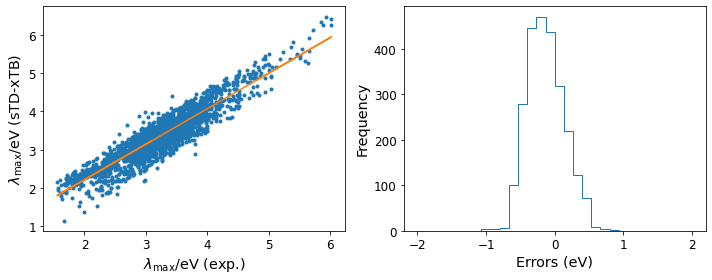

In [6]:
#plt.plot(data['lambda_max_stda'],data['lambda_max_exp_nm'],'.')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.plot(train_data.abs_max_ev,train_data.std_max_ev,'.')
ax1.plot(train_data.abs_max_ev,plot_regression_ys(train_data.abs_max_ev,train_data.std_max_ev))
ax1.set_xlabel('$\lambda_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax1.set_ylabel('$\lambda_\mathrm{max}$/eV (sTD-xTB)',fontsize='x-large')
ax1.tick_params(labelsize='large')
ax2.hist(y_train,bins=30,range=(-2,2),histtype='step')
ax2.set_xlabel('Errors (eV)',fontsize='x-large')
ax2.set_ylabel('Frequency',fontsize='x-large')
ax2.tick_params(labelsize='large')
plt.tight_layout()
plt.show()

In [7]:
print('MAE of abs. maxima from sTD-xTB vs Experimental result for training set: %3f eV'%
      mean_absolute_error(train_data['abs_max_ev'],train_data['std_max_ev'])
     )

MAE of abs. maxima from sTD-xTB vs Experimental result for training set: 0.244669 eV


## Preparing the models
Here we use `scikit-learn`'s linear regression, lasso, SVM regression and multi-layer perceptron regression models. The models are provided by a function which returns the average MAE from 5-fold cross-validation. This average MAE is minimised by `optuna` during hyperparameter optimisation.

In [8]:
# learning models
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# cross_validation
from sklearn.model_selection import cross_val_score

In [9]:
def get_model(trial,m_name,X_input,y_input,std_dev_list,return_model=False):
    """ Provides an optimization function for Optuna"""
    # trial (optuna trial object) = required for optuna
    # m_name (string) = type of regression model
    # X_input (2D array)
    # y_input (1D array)
    # std_dev_list (list) = to store the standard deviations for each call
    # return_model (bool) = whether to return fitted model, or just the average cross-val error
    if m_name == 'svm': #SVR
        #kernel_val = trial.suggest_categorical('kernel_val',['rbf','poly'])
        #degree_val = trial.suggest_categorical('degree_val',[3,5])
        C_val = trial.suggest_loguniform('C_val',1e-6,1e+6)
        gamma_val = trial.suggest_loguniform('gamma_val',1e-6,1e+6)
        epsilon_val = trial.suggest_loguniform('epsilon_val',1e-3,1e+3)
        model = SVR(C=C_val,gamma=gamma_val,epsilon=epsilon_val,cache_size=300)
    elif m_name == 'rf': # random forest
        #max_depth_list.append(None)
        n_estim_val = trial.suggest_int('n_estim_val',10,100,step=10)
        max_feat_val = trial.suggest_categorical('max_feat_val',['auto','sqrt','log2'])
        max_depth_val = trial.suggest_categorical('max_depth_val',[int(x) for x in np.linspace(10,110,num=11)])
        min_samp_spl_val = trial.suggest_categorical('min_samp_spl_val',[2,5,10])
        min_samp_lf_val = trial.suggest_categorical('min_samp_lf_val',[1,2,4])
        #bootstrap_val = trial.suggest_categorical('bootstrap_val',[True,False])
        max_samp_val = trial.suggest_categorical('max_samp_val',[0.9,0.5,0.8])
        model = RandomForestRegressor(
            n_estimators=n_estim_val,
            max_features=max_feat_val,
            max_depth=max_depth_val,
            min_samples_split=min_samp_spl_val,
            min_samples_leaf=min_samp_lf_val,
            bootstrap=True,
            max_samples=max_samp_val
        )
    elif m_name == 'lasso': # Lasso
        alpha_val = trial.suggest_loguniform('alpha_val',1e-3,1000)
        model = Lasso(alpha=alpha_val,max_iter=90000,tol=0.5e-3)
    elif m_name == 'mlp': # neural network
        hidden_layer_val = trial.suggest_categorical('hidden_layer_val',[(100,),(50,100,50),(75,50,20)])
        activation_val = trial.suggest_categorical('activation_val',['tanh','relu'])
        #solver_val = trial.suggest_categorical('solver_val',['adam','lbfgs'])
        alpha_val = trial.suggest_loguniform('alpha_val',0.0001,10)
        batch_size_val = trial.suggest_categorical('batch_size_val',[64,128,'auto'])
        learning_rt_val = trial.suggest_categorical('learning_rt_val',['constant','adaptive'])
        model= MLPRegressor(
            max_iter=50000,
            #max_fun=50000,
            hidden_layer_sizes=hidden_layer_val,
            activation=activation_val,
            #solver=solver_val,
            alpha=alpha_val,
            batch_size=batch_size_val,
            learning_rate=learning_rt_val
        )
    else:
        raise ValueError('Unidentified model name!')
    if return_model:
        # in return_result mode, it returns the fitted model
        model.fit(X_input,y_input)
        return model
    else:
        # else fit the model and return data
        score = cross_val_score(model,X_input,y_input,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
        std_dev_list.append(score.std())
        return -score.mean()

## Preparing the fingerprints
We use atom-pair fingerprint, morgan fingerprint, MACCS keys, RDK topological fingerprint from `rdkit` and descriptors from `mordred`

In [10]:
import subprocess
import random
import io
import sys
import glob

# saving and reloading expensive data
import pickle

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
#from sklearn.model_selection import cross_val_score

# for fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.AtomPairs.Pairs import GetHashedAtomPairFingerprint
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint
from rdkit.Chem.rdMolDescriptors import GetMACCSKeysFingerprint
from rdkit.Chem.rdmolops import RDKFingerprint
from mordred import Calculator, descriptors

In [11]:
%%capture
try:
    with open('mordred_selected_columns.pkl','rb') as fh:
        mordred_select_cols = pickle.load(fh)
        if len(mordred_select_cols) != 1284:
            raise Exception('Corrupted pickle file for available descriptors in Mordred')
except:
    dummy_list = []
    for dummy_file in glob.iglob('./final_xtb_opt/*.mol'):
        dummy_list.append(Chem.MolFromMolFile(dummy_file))
    for dummy_file in glob.iglob('../test/final_xtb_opt/*.mol'):
        dummy_list.append(Chem.MolFromMolFile(dummy_file))
    dummy_calc = Calculator(descriptors,ignore_3D=False)
    dummy_df = dummy_calc.pandas(dummy_list)
    # extract numerical columns that are available for all the molecules
    mordred_select_cols = list(dummy_df.select_dtypes(exclude='object').columns)
    dummy_calc = dummy_list = dummy_df = None # free up memory
    with open('mordred_selected_columns.pkl','wb') as fh:
        pickle.dump(mordred_select_cols,fh,pickle.HIGHEST_PROTOCOL)

In [12]:
# solvent epsilon_opt vs epsilon_0
solvent_to_eps = {'1,2-dichloroethane':[1.4448**2,10.125], 'acetone':[1.3588**2,20.493],
                  'acetonitrile':[1.3442**2,35.688],'benzene':[1.5011**2,2.2706],
                  'carbon tetrachloride':[1.4601**2,2.2280], 'chloroform':[1.4459**2,4.7113],
                  'cyclohexane':[1.4266**2,2.0165],'dichloromethane':[1.4242**2,8.93],'diethyl ether':[1.3526**2,4.24],
                  'dimethylformamide':[1.4305**2,37.219],'dimethylsulfoxide':[1.4783**2,46.826],
                  'dioxane':[1.4224**2,2.2099], 'ethanol':[1.3611**2,24.852],'ethyl ethanoate':[1.3723**2,5.9867],
                  'hexane':[1.3749**2,1.8819], 'methanol':[1.3288**2,32.613],'methylcyclohexane':[1.4231**2,2.024],
                  'n-heptane':[1.3878**2,1.9113], 'n-pentane':[1.3575**2,1.8371],'tetrahydrofuran':[1.4050**2,7.4257],
                  'toluene':[1.4961**2,2.3741], 'water':[1.3328**2,78.355]}

def get_fingerprint(f_name,df,test_or_train,return_unmodified=False):
    # f_name (str) = name of the fingerprint
    # df (pandas DataFrame) = dataframe containing solvent SMILES and solvent information
    # test_or_train (string) = 'test' or 'train' <= for reading the appropriate molfiles
    # return_unmodified (bool) = whether to return the unmodified array
    """ Returns the fingerprints from a pandas dataframe with a column named SMILES"""
    if not 'SMILES' in df.columns:
        raise Exception("Dataframe passed to get_fingerprint() must have 'SMILES' column")
    if not 'solvent' in df.columns:
        raise Exception("Dataframe passed to get_fingerprint() must have 'solvent' column")
    #smi_string_list = list(df.SMILES)
    if f_name == 'MORDRED':
        try: # save mordred data as it takes time to calculate
            if test_or_train == 'train':
                with open('mordred_train_data.pkl','rb') as fh:
                    init_array = pickle.load(fh)
                if len(init_array) != 2492:
                    raise Exception('Corrupted pickle file for mordred training data!')
            elif test_or_train == 'test':
                with open('mordred_test_data.pkl','rb') as fh:
                    init_array = pickle.load(fh)
                if len(init_array) != 631:
                    raise Exception('Corrupted pickle file for mordred test data!')
        except:
            mols_list = []
            for index in range(len(df)):
                # read SMILES
                if test_or_train == 'train':
                    filename = './final_xtb_opt/train-'+str(df.num[index])+'.mol'
                elif test_or_train == 'test':
                    filename = '../test/final_xtb_opt/test-'+str(df.num[index])+'.mol'
                smi_molecule = Chem.MolFromMolFile(filename)
                mols_list.append(smi_molecule)
            calc = Calculator(descriptors,ignore_3D=False)
            # need to suppress warnings from mordred
            prev_stdout = sys.stdout
            sys.stdout = io.StringIO()
            molprop_data = calc.pandas(mols_list)
            sys.stdout = prev_stdout
            molprop_data = molprop_data[mordred_select_cols]
            molprop_data['solvent_eps_opt'] = df.solvent.apply(lambda x: solvent_to_eps[x][0])
            molprop_data['solvent_eps_0'] = df.solvent.apply(lambda x: solvent_to_eps[x][1])
            #molprop_data = molprop_data.select_dtypes(exclude=['object'])
            init_array = molprop_data.astype(float).to_numpy()
            if test_or_train == 'train':
                with open('mordred_train_data.pkl','wb') as fh:
                    pickle.dump(init_array,fh,pickle.HIGHEST_PROTOCOL)
            elif test_or_train == 'test':
                with open('mordred_test_data.pkl','wb') as fh:
                    pickle.dump(init_array,fh,pickle.HIGHEST_PROTOCOL)
    elif f_name == 'NOISE': # simulate a 2048-bit fingerprint
        num_list = [0,1,2,3,4,5,6,7,8,9,10,11,12] # to simulate fingerprints
        init_array = np.zeros((len(df),2050),dtype=np.float64)
        if test_or_train == 'train':
            random.seed(800)
        else: # this is to ensure same NOISE is generated everytime the model is called
            random.seed(200)
        for index in range(len(df)):
            init_array[index,:-2] = random.choices(num_list,k=2048,weights=[400,30,5,2,1,1,1,1,0.5,0.5,0.5,0.5,0.5])
            init_array[index,-2:] = solvent_to_eps[df.loc[index,'solvent']]
        random.seed() # reset the random seeding
    else:
        if f_name == 'APFP': # 2048-bit hashed APFP
            init_array = np.zeros((len(df),2050),dtype=np.float64)
            generator_func = GetHashedAtomPairFingerprint
            params = {'nBits':2048}
        elif f_name == 'ECFP4': # 2048-bit hashed ECFP with radius=2
            init_array = np.zeros((len(df),2050),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = {'radius':2,'nBits':2048}
        elif f_name == 'ECFP6': # 2048-bit hashed ECFP with radius=3
            init_array = np.zeros((len(df),2050),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = {'radius':3,'nBits':2048}
        elif f_name == 'ECFP8': # 2048-bit hashed ECFP with radius=4
            init_array = np.zeros((len(df),2050),dtype=np.float64)
            generator_func = GetHashedMorganFingerprint
            params = {'radius':4,'nBits':2048}
        #elif f_name == 'ECFP8_4096': #4096-bit hashed ECFP with radius=4
        #    init_array = np.zeros((len(df),4097),dtype=np.float64)
        #    generator_func = GetHashedMorganFingerprint
        #    params = [4,4096]
        elif f_name == 'RDK': # RDK Fingerprint 2048-bit (default options)
            init_array = np.zeros((len(df),2050),dtype=np.float64)
            generator_func = RDKFingerprint
            params = {'minPath':1,'maxPath':7,'fpSize':2048}
        elif f_name == 'MACCS':
            init_array = np.zeros((len(df),169),dtype=np.float64)
            generator_func = GetMACCSKeysFingerprint
            params = {}
        else:
            raise Exception('Unknown fingerprint name!')
        # now generate the fingerprint
        for index in range(len(df)):
            if test_or_train == 'train':
                filename = './final_xtb_opt/train-'+str(df.num[index])+'.mol'
            elif test_or_train == 'test':
                filename = '../test/final_xtb_opt/test-'+str(df.num[index])+'.mol'
            mol = Chem.MolFromMolFile(filename)
            if mol is None:
                raise Exception('Error in reading SMILES')
            init_array[index,:-2] = list(generator_func(mol,**params))
            init_array[index,-2:] = solvent_to_eps[df.loc[index,'solvent']]

    if return_unmodified:
        # return unmodified array and preprocessor
        return init_array
    else:
            # calculation done, now process the data for learning
        preprocessor = Pipeline([
        ('variance',VarianceThreshold()),
        ('scaler',StandardScaler()),
        ('pca',PCA(n_components=0.99,svd_solver='full')) #select components that explain upto 99% of variation
        #('selective_pca',ColumnTransformer(
        #    transformers=[('pca',PCA(n_components=0.95,svd_solver='full'),[x for x in range(init_array.shape[1]-1)])],
        #    remainder='passthrough')
        #) only for fingerprint not solvent epsilon
        ])
        fin_array = preprocessor.fit_transform(init_array)
        return fin_array, preprocessor

# Fitting models
The package `optuna` is used for Bayesian hyperparameter optimisation (using the default tree-of-Parzen algorithm). The best results for each model and each fingerprint are stored in pickle files. The training and hyperparameter optimisation is done on training set, then the optimised model is used on the training and the test set.

In [13]:
# optimization
import optuna

# optuna prints a lot of information messages
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
from optuna.exceptions import ExperimentalWarning

In [14]:
fprint_type = ['APFP','ECFP4','ECFP6','ECFP8','RDK','MACCS','MORDRED','NOISE']

In [15]:
# for plotting
def running_min_val(list_of_val):
    # goes through a list taking the minimum so far
    min_vals = []
    running_min = list_of_val[0]
    min_vals.append(running_min)
    for i in list_of_val[1:]:
        if i < running_min:
            running_min = i
        min_vals.append(running_min)
    return min_vals

In [23]:
# Show the number of variables (features) in each type of fingerprint
print('Number of features')
print('-------------------')
for fprint in fprint_type:
    print(fprint,':',get_fingerprint(fprint,train_data,'train')[0].shape[1])

Number of features
-------------------
APFP : 937
ECFP4 : 1157
ECFP6 : 1290
ECFP8 : 1357
RDK : 1020
MACCS : 109
MORDRED : 167
NOISE : 1715


# SVM

In [34]:
svm_best_params = {} # dict to store best params for each fingerprint
svm_error_values = {} # dict to store the error value with each trial iteration
svm_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    svm_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'svm',X_train,y_train,svm_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    svm_best_params[fprint] = study.best_trial
    svm_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
# save into pickle
#with open('svm_results_save.pkl', 'wb') as fh:
#    pickle.dump((svm_best_params,svm_error_values,svm_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload pickle if needed
#with open('svm_results_save.pkl', 'rb') as fh:
#    svm_best_params,svm_error_values,svm_std_devs = pickle.load(fh)#

In [17]:
print('Best MAEs of cross-validation training (SVM)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(svm_error_values[fprint])
    best_mae = svm_error_values[fprint][min_index]
    best_std = svm_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (SVM)
----
APFP : 0.158 (std.dev: 0.007)
ECFP4 : 0.146 (std.dev: 0.005)
ECFP6 : 0.144 (std.dev: 0.004)
ECFP8 : 0.147 (std.dev: 0.004)
RDK : 0.127 (std.dev: 0.005)
MACCS : 0.149 (std.dev: 0.004)
MORDRED : 0.144 (std.dev: 0.144)
NOISE : 0.213 (std.dev: 0.213)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


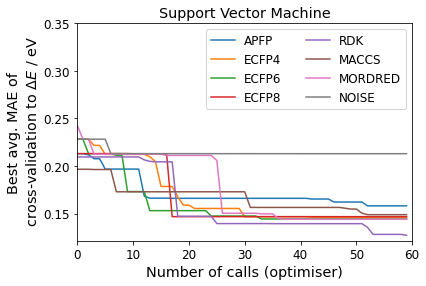

In [36]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(svm_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2,fontsize='large')
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.35)
plt.xlabel('Number of calls (optimiser)',fontsize='x-large')
plt.ylabel('Best avg. MAE of\n cross-validation to $\Delta E$ / eV',fontsize='x-large')
plt.title('Support Vector Machine',fontsize='x-large')
#plt.savefig('SVM-optimisation.eps',bbox_inches='tight',dpi=512)
plt.show()

In [19]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    predictor = get_model(svm_best_params[fprint],'svm',X_train,y_train,[],True) # get fitted model on training data
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.245 ; std. dev. = 0.264
APFP : MAE = 0.083 ; std. dev. = 0.151
ECFP4 : MAE = 0.095 ; std. dev. = 0.154
ECFP6 : MAE = 0.012 ; std. dev. = 0.051
ECFP8 : MAE = 0.016 ; std. dev. = 0.058
RDK : MAE = 0.041 ; std. dev. = 0.097
MACCS : MAE = 0.065 ; std. dev. = 0.121
MORDRED : MAE = 0.095 ; std. dev. = 0.144
NOISE : MAE = 0.213 ; std. dev. = 0.264


In [20]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = get_model(svm_best_params[fprint],'svm',X_train,y_train,[],True) # get fitted model on training data
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.231 ; std. dev. = 0.263
APFP : MAE = 0.097 ; std. dev. = 0.167
ECFP4 : MAE = 0.097 ; std. dev. = 0.153
ECFP6 : MAE = 0.035 ; std. dev. = 0.087
ECFP8 : MAE = 0.038 ; std. dev. = 0.088
RDK : MAE = 0.052 ; std. dev. = 0.109
MACCS : MAE = 0.073 ; std. dev. = 0.128
MORDRED : MAE = 0.106 ; std. dev. = 0.159
NOISE : MAE = 0.216 ; std. dev. = 0.263


#### Plot the SVM/ECFP6 data for training set

In [21]:
X_train = get_fingerprint('ECFP6',train_data,'train')[0] # get training data, preprocessed
predictor = get_model(svm_best_params['ECFP6'],'svm',X_train,y_train,[],True) # get fitted model
y_train_pred = predictor.predict(X_train)
abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)

Training set (SVM/ECFP6)
------------------------
Before fitting: MAE = 0.245
                std. dev. = 0.264
After corrections: MAE = 0.012
                   std. dev. = 0.051


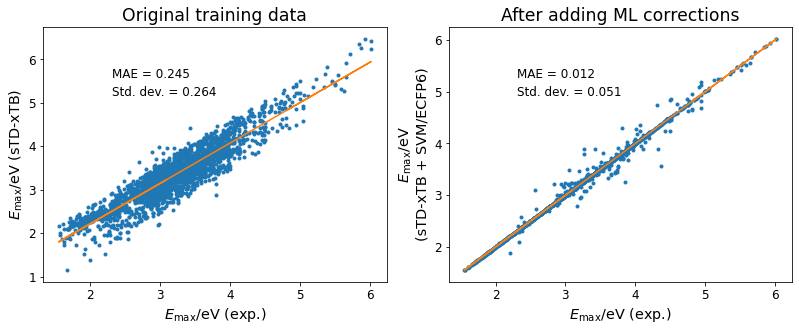

In [23]:
MAE_before = mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev)
STD_before = np.std(y_train)
MAE_after = mean_absolute_error(train_data.abs_max_ev,abs_max_pred)
STD_after = np.std(np.array(train_data.abs_max_ev)-abs_max_pred)
print('Training set (SVM/ECFP6)')
print('------------------------')
print('Before fitting: MAE = %.3f'%MAE_before)
print('                std. dev. = %.3f'%STD_before)
print('After corrections: MAE = %.3f'%MAE_after)
print('                   std. dev. = %.3f'%STD_after)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11.2,4.7))
ax1.plot(train_data.abs_max_ev,train_data.std_max_ev,'.')
ax1.plot(train_data.abs_max_ev,plot_regression_ys(train_data.abs_max_ev,train_data.std_max_ev))
ax1.set_xlabel('$E_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax1.set_ylabel('$E_\mathrm{max}$/eV (sTD-xTB)',fontsize='x-large')
ax1.tick_params(labelsize='large')
ax1.set_title('Original training data',fontsize='xx-large')
ax1.annotate("MAE = %.3f"%MAE_before,(0.2,0.8),fontsize='large',xycoords='axes fraction')
ax1.annotate("Std. dev. = %.3f"%STD_before,(0.2,0.73),fontsize='large',xycoords='axes fraction')

ax2.plot(train_data.abs_max_ev,abs_max_pred,'.')
ax2.plot(train_data.abs_max_ev,plot_regression_ys(train_data.abs_max_ev,abs_max_pred))
ax2.set_xlabel('$E_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax2.set_ylabel('$E_\mathrm{max}$/eV\n(sTD-xTB + SVM/ECFP6)',fontsize='x-large')
ax2.tick_params(labelsize='large')
ax2.set_title('After adding ML corrections',fontsize='xx-large')
ax2.annotate("MAE = %.3f"%MAE_after,(0.2,0.8),fontsize='large',xycoords='axes fraction')
ax2.annotate("Std. dev. = %.3f"%STD_after,(0.2,0.73),fontsize='large',xycoords='axes fraction')
plt.tight_layout()
#plt.savefig('SVM-ECFP6-training-eV.eps',bbox_inches='tight',dpi=1000)
plt.show()

#### Plot the SVM/ECFP6 data for test set

In [24]:
# ECFP6 with SVM is the best data, so we plot that
X_train, preproc = get_fingerprint('ECFP6',train_data,'train') # take fitted preprocessor for training data
X_test = preproc.transform(get_fingerprint('ECFP6',test_data,'test',True)) # transform unmodified fingerprints
predictor = get_model(svm_best_params['ECFP6'],'svm',X_train,y_train,[],True)
y_test_pred = predictor.predict(X_test)
abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
test_data['svm_ecfp6_pred'] = abs_max_pred # put it into dataframe for outlier analysis

In [25]:
#test_data.to_csv('../../TD-DFT/test_set_with_svm_preds.csv') # save for tddft results

Test set (SVM/ECFP6)
------------------------
Before fitting: MAE = 0.231
                std. dev. = 0.263
After corrections: MAE = 0.035
                   std. dev. = 0.087


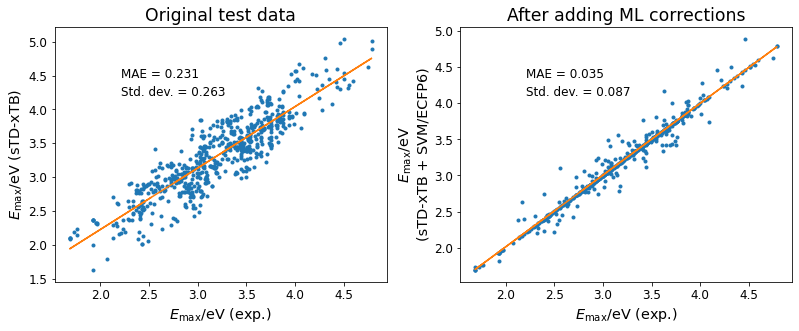

In [27]:
# print stats
MAE_before = mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev)
STD_before = np.std(y_test)
MAE_after = mean_absolute_error(test_data.abs_max_ev,abs_max_pred)
STD_after = np.std(np.array(test_data.abs_max_ev)-abs_max_pred)
print('Test set (SVM/ECFP6)')
print('------------------------')
print('Before fitting: MAE = %.3f'%MAE_before)
print('                std. dev. = %.3f'%STD_before)
print('After corrections: MAE = %.3f'%MAE_after)
print('                   std. dev. = %.3f'%STD_after)
# now plot the results
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11.2,4.7))
ax1.plot(test_data.abs_max_ev,test_data.std_max_ev,'.')
ax1.plot(test_data.abs_max_ev,plot_regression_ys(test_data.abs_max_ev,test_data.std_max_ev))
ax1.set_xlabel('$E_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax1.set_ylabel('$E_\mathrm{max}$/eV (sTD-xTB)',fontsize='x-large')
ax1.tick_params(labelsize='large')
ax1.set_title('Original test data',fontsize='xx-large')
ax1.annotate("MAE = %.3f"%MAE_before,(0.2,0.8),fontsize='large',xycoords='axes fraction')
ax1.annotate("Std. dev. = %.3f"%STD_before,(0.2,0.73),fontsize='large',xycoords='axes fraction')

ax2.plot(test_data.abs_max_ev,abs_max_pred,'.')
ax2.plot(test_data.abs_max_ev,plot_regression_ys(test_data.abs_max_ev,abs_max_pred))
ax2.set_xlabel('$E_\mathrm{max}$/eV (exp.)',fontsize='x-large')
ax2.set_ylabel('$E_\mathrm{max}$/eV\n(sTD-xTB + SVM/ECFP6)',fontsize='x-large')
ax2.tick_params(labelsize='large')
ax2.set_title('After adding ML corrections',fontsize='xx-large')
ax2.annotate("MAE = %.3f"%MAE_after,(0.2,0.8),fontsize='large',xycoords='axes fraction')
ax2.annotate("Std. dev. = %.3f"%STD_after,(0.2,0.73),fontsize='large',xycoords='axes fraction')
plt.tight_layout()
#plt.savefig('SVM-ECFP6-test-eV.eps',bbox_inches='tight',dpi=1000)
plt.show()

#### Analysis of outliers (SVM/ECFP6):

In [28]:
import rdkit.Chem.Draw
from rdkit import DataStructs
# pick the outliers from SVM/ECFP6
test_data['diff_svm_exp'] = test_data.svm_ecfp6_pred - test_data.abs_max_ev
# sort according to the difference and then select the top 20 with the highest errors and get their SMILES
outliers = test_data[abs(test_data.diff_svm_exp)>0.2].copy().sort_values('diff_svm_exp',ascending=False).iloc[:20]
smi_outliers = list(outliers.sort_values('diff_svm_exp',ascending=False).iloc[:20].SMILES)
mols_outliers = [Chem.MolFromSmiles(x) for x in smi_outliers]

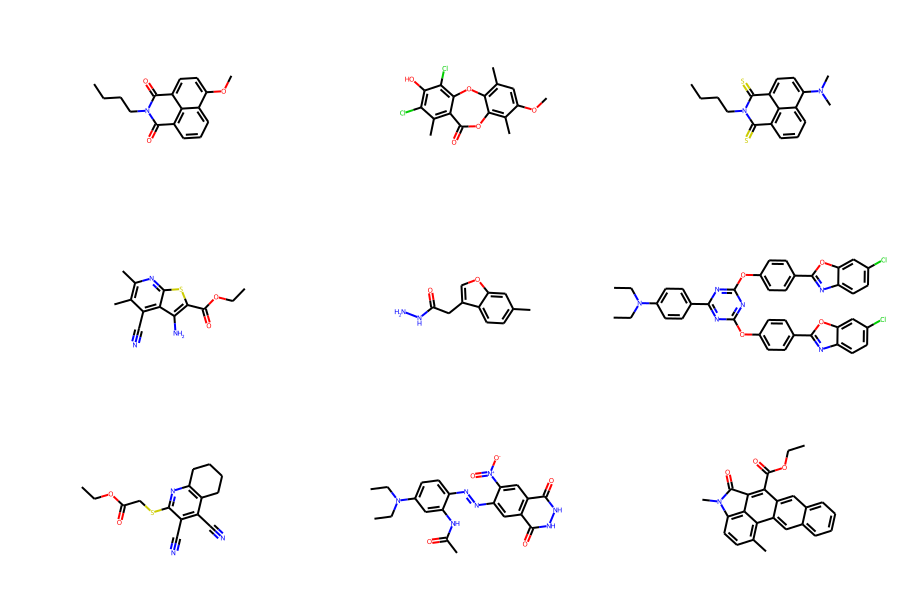

In [29]:
# draw 9 outliers
rdkit.Chem.Draw.MolsToGridImage(mols_outliers[:9],subImgSize=(300,200)) # => can't see any trend ???

In [30]:
smi_outliers

['CCCCN1C(=O)c2cccc3c(OC)ccc(c23)C1=O',
 'COc1cc(C)c2c(c1C)OC(=O)c1c(C)c(Cl)c(O)c(Cl)c1O2',
 'CCCCN1C(=S)c2cccc3c(N(C)C)ccc(c23)C1=S',
 'CCOC(=O)c1sc2nc(C)c(C)c(C#N)c2c1N',
 'Cc1ccc2c(CC(=O)NN)coc2c1',
 'CCN(CC)c1ccc(-c2nc(Oc3ccc(-c4nc5ccc(Cl)cc5o4)cc3)nc(Oc3ccc(-c4nc5ccc(Cl)cc5o4)cc3)n2)cc1',
 'CCOC(=O)CSc1nc2c(c(C#N)c1C#N)CCCC2',
 'CCN(CC)c1ccc(/N=N/c2cc3c(=O)[nH][nH]c(=O)c3cc2[N+](=O)[O-])c(NC(C)=O)c1',
 'CCOC(=O)c1c2c3c(ccc(C)c3c3cc4ccccc4cc13)N(C)C2=O',
 'COc1ccc(C#Cc2nc(C#Cc3ccc(OC)cc3)c(C#Cc3ccc(OC)cc3)c(C#Cc3ccc(OC)cc3)c2C#Cc2ccc(OC)cc2)cc1',
 'Cc1cc(C)nc(N)n1',
 'O=[N+]([O-])c1ccc(O)c(O)c1',
 'CCCCc1cc(-c2cccc(COC)c2)oc1-c1cccc(-c2oc(-c3cccc(COC)c3)cc2CCCC)c1',
 'CC(=O)c1ccc(/C=C/C=C/C2=NC3C(=O)NC(N)=NC3N2[C@H]2C[C@H](O)[C@@H](CO)O2)cc1',
 'N#C/C(=C\\c1ccc(Cl)cc1)c1nc2ccccc2s1',
 'c1ccc2c(c1)Sc1ccccc1N2c1ccc2c(c1)C1(c3ccccc3-c3ccccc31)c1cc(N3c4ccccc4Sc4ccccc43)ccc1-2',
 'CC1=[N+]2C(=c3c4c5ccccc5cc5cccc(c6cc(C)n(c36)[B-]2(F)F)c54)C=C1',
 'CN(C)c1ccc(/C=C/c2ccc([N+](=O)[O-])c(O)

In [31]:
similarity_array = np.zeros((len(mols_outliers),len(mols_outliers)),dtype=np.float64)
for i in range(similarity_array.shape[0]):
    for j in range(similarity_array.shape[1]):
        fp_a = GetHashedMorganFingerprint(mols_outliers[i],radius=3,nBits=2048)
        fp_b = GetHashedMorganFingerprint(mols_outliers[j],radius=3,nBits=2048)
        similarity_array[i,j] = DataStructs.DiceSimilarity(fp_a,fp_b)
outlier_mol_names = ['E'+str(i) for i in range(similarity_array.shape[0])]
# get the similarity square and save it 
#pd.DataFrame(similarity_array,index=outlier_mol_names,columns=outlier_mol_names).to_csv('similarity_score_outlier.csv')

In [32]:
# plot number of neighbours vs remnant deviation
train_fps = list(
    train_data.SMILES.apply(lambda x: GetHashedMorganFingerprint(
        Chem.MolFromSmiles(x),radius=3,nBits=2048)
    )) # get ECFP6 fingerprints for training set
num_similarity_list = []
remnant_dev_list = []
for num,row in test_data.iterrows():
    this_fp = GetHashedMorganFingerprint(Chem.MolFromSmiles(row['SMILES']),radius=3,nBits=2048)
    similarities_with_train = DataStructs.BulkDiceSimilarity(this_fp,train_fps)
    # get the number of mols in training set with similarity score > 0.7
    num_similarity_list.append(sum(1 for x in similarities_with_train if x >= 0.7))
    remnant_dev_list.append(row['diff_svm_exp'])
remnant_dev_list = np.abs(np.array(remnant_dev_list)) # take absolute values
num_similarity_list = np.array(num_similarity_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


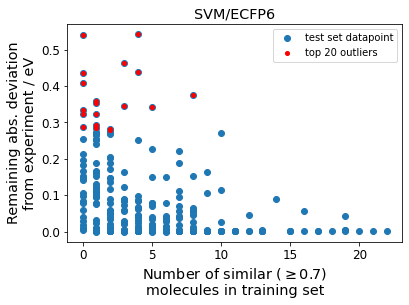

In [34]:
top_20_mask = np.argsort(remnant_dev_list)[-20:]
plt.plot(num_similarity_list,remnant_dev_list,'o',label='test set datapoint')
plt.plot(num_similarity_list[top_20_mask],remnant_dev_list[top_20_mask],'or',label='top 20 outliers',ms=4)
plt.xlabel('Number of similar ($\geq0.7$)\nmolecules in training set',fontsize='x-large')
plt.ylabel('Remaining abs. deviation\nfrom experiment / eV',fontsize='x-large')
plt.tick_params(labelsize='large')
plt.title('SVM/ECFP6',fontsize='x-large')
plt.legend()
#plt.savefig('SVM-ECFP6-similarity-vs-outlier.eps',dpi=600,bbox_inches='tight')
plt.show()

## Lasso

In [62]:
lasso_best_params = {} # dict to store best params for each fingerprint
lasso_error_values = {} # dict to store the error value with each trial iteration
lasso_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    lasso_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'lasso',X_train,y_train,lasso_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    lasso_best_params[fprint] = study.best_trial
    lasso_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
# save
#with open('lasso_results_save.pkl', 'wb') as fh:
#    pickle.dump((lasso_best_params,lasso_error_values,lasso_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload
#with open('lasso_results_save.pkl', 'rb') as fh:
#    lasso_best_params,lasso_error_values,lasso_std_devs = pickle.load(fh)

In [39]:
print('Best MAEs of cross-validation training (Lasso)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(lasso_error_values[fprint])
    best_mae = lasso_error_values[fprint][min_index]
    best_std = lasso_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (Lasso)
----
APFP : 0.173 (std.dev: 0.007)
ECFP4 : 0.159 (std.dev: 0.006)
ECFP6 : 0.158 (std.dev: 0.005)
ECFP8 : 0.161 (std.dev: 0.005)
RDK : 0.145 (std.dev: 0.004)
MACCS : 0.184 (std.dev: 0.006)
MORDRED : 0.171 (std.dev: 0.007)
NOISE : 0.213 (std.dev: 0.005)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


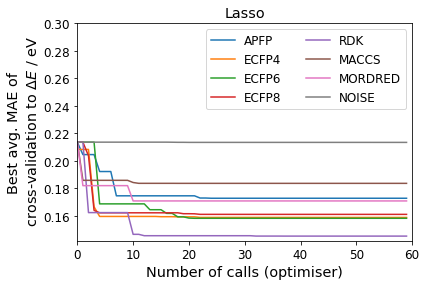

In [17]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(lasso_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2,fontsize='large')
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.3)
plt.xlabel('Number of calls (optimiser)',fontsize='x-large')
plt.ylabel('Best avg. MAE of\n cross-validation to $\Delta E$ / eV',fontsize='x-large')
plt.title('Lasso',fontsize='x-large')
#plt.savefig('lasso-optimisation.eps',bbox_inches='tight',dpi=600)
plt.show()

In [31]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    predictor = get_model(lasso_best_params[fprint],'lasso',X_train,y_train,[],True) #get fitted model on training data
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.245 ; std. dev. = 0.264
APFP : MAE = 0.134 ; std. dev. = 0.180
ECFP4 : MAE = 0.119 ; std. dev. = 0.160
ECFP6 : MAE = 0.130 ; std. dev. = 0.173
ECFP8 : MAE = 0.132 ; std. dev. = 0.176
RDK : MAE = 0.106 ; std. dev. = 0.144
MACCS : MAE = 0.175 ; std. dev. = 0.224
MORDRED : MAE = 0.158 ; std. dev. = 0.207
NOISE : MAE = 0.213 ; std. dev. = 0.263


In [32]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = get_model(lasso_best_params[fprint],'lasso',X_train,y_train,[],True) #get fitted model on training dat
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.231 ; std. dev. = 0.263
APFP : MAE = 0.145 ; std. dev. = 0.198
ECFP4 : MAE = 0.120 ; std. dev. = 0.168
ECFP6 : MAE = 0.129 ; std. dev. = 0.172
ECFP8 : MAE = 0.131 ; std. dev. = 0.174
RDK : MAE = 0.106 ; std. dev. = 0.147
MACCS : MAE = 0.181 ; std. dev. = 0.234
MORDRED : MAE = 0.164 ; std. dev. = 0.216
NOISE : MAE = 0.214 ; std. dev. = 0.263


## Multi-Layer Perceptron

In [70]:
mlp_best_params = {} # dict to store best params for each fingerprint
mlp_error_values = {} # dict to store the error value with each trial iteration
mlp_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    mlp_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'mlp',X_train,y_train,mlp_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        warnings.filterwarnings(action='ignore',message='Choices for a categorical distribution should be a tuple')
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    mlp_best_params[fprint] = study.best_trial
    mlp_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [18]:
# save
#with open('mlp_results_save.pkl', 'wb') as fh:
#    pickle.dump((mlp_best_params,mlp_error_values,mlp_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload
#with open('mlp_results_save.pkl', 'rb') as fh:
#    mlp_best_params,mlp_error_values,mlp_std_devs = pickle.load(fh)

In [24]:
print('Best MAEs of cross-validation training (MLP)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(mlp_error_values[fprint])
    best_mae = mlp_error_values[fprint][min_index]
    best_std = mlp_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (MLP)
----
APFP : 0.157 (std.dev: 0.006)
ECFP4 : 0.146 (std.dev: 0.006)
ECFP6 : 0.146 (std.dev: 0.003)
ECFP8 : 0.149 (std.dev: 0.004)
RDK : 0.133 (std.dev: 0.004)
MACCS : 0.156 (std.dev: 0.007)
MORDRED : 0.152 (std.dev: 0.006)
NOISE : 0.214 (std.dev: 0.004)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


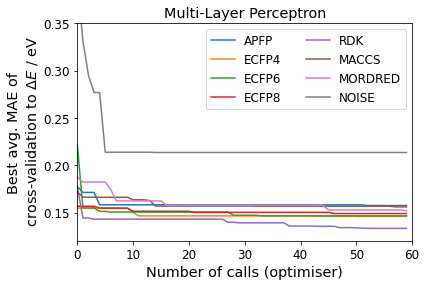

In [20]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(mlp_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2,fontsize='large')
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.35)
plt.xlabel('Number of calls (optimiser)',fontsize='x-large')
plt.ylabel('Best avg. MAE of\n cross-validation to $\Delta E$ / eV',fontsize='x-large')
plt.title('Multi-Layer Perceptron',fontsize='x-large')
#plt.savefig('mlp-optimisation.eps',bbox_inches='tight',dpi=600)
plt.show()

In [26]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',message='Choices for a categorical distribution should be a tuple')
        predictor = get_model(mlp_best_params[fprint],'mlp',X_train,y_train,[],True) # get fitted model
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.245 ; std. dev. = 0.264
APFP : MAE = 0.103 ; std. dev. = 0.149
ECFP4 : MAE = 0.086 ; std. dev. = 0.124
ECFP6 : MAE = 0.082 ; std. dev. = 0.115
ECFP8 : MAE = 0.028 ; std. dev. = 0.044
RDK : MAE = 0.082 ; std. dev. = 0.118
MACCS : MAE = 0.099 ; std. dev. = 0.131
MORDRED : MAE = 0.120 ; std. dev. = 0.163
NOISE : MAE = 0.213 ; std. dev. = 0.264


In [27]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',message='Choices for a categorical distribution should be a tuple')
        predictor = get_model(mlp_best_params[fprint],'mlp',X_train,y_train,[],True) #get fitted model on training dat
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.231 ; std. dev. = 0.263
APFP : MAE = 0.116 ; std. dev. = 0.170
ECFP4 : MAE = 0.098 ; std. dev. = 0.144
ECFP6 : MAE = 0.089 ; std. dev. = 0.125
ECFP8 : MAE = 0.054 ; std. dev. = 0.095
RDK : MAE = 0.084 ; std. dev. = 0.125
MACCS : MAE = 0.111 ; std. dev. = 0.151
MORDRED : MAE = 0.128 ; std. dev. = 0.175
NOISE : MAE = 0.214 ; std. dev. = 0.263


## Random Forest

In [17]:
rf_best_params = {} # dict to store best params for each fingerprint
rf_error_values = {} # dict to store the error value with each trial iteration
rf_std_devs = {} # dict to store the std. deviations for each trial iteration
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0]
    rf_std_devs[fprint] = []
    wrapper_func = lambda trial : get_model(trial,'rf',X_train,y_train,rf_std_devs[fprint])
    study = optuna.create_study()
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore',category=ExperimentalWarning)
        study.optimize(wrapper_func,n_trials=60,show_progress_bar=True)
    rf_best_params[fprint] = study.best_trial
    rf_error_values[fprint] = list(study.trials_dataframe()['value'])

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [21]:
# save
#with open('rf_results_save.pkl', 'wb') as fh:
#    pickle.dump((rf_best_params,rf_error_values,rf_std_devs),fh,pickle.HIGHEST_PROTOCOL)
# reload
#with open('rf_results_save.pkl','rb') as fh:
#    rf_best_params,rf_error_values,rf_std_devs = pickle.load(fh)

In [19]:
print('Best MAEs of cross-validation training (RF)')
print('----')
for fprint in fprint_type:
    min_index = np.argmin(rf_error_values[fprint])
    best_mae = rf_error_values[fprint][min_index]
    best_std = rf_std_devs[fprint][min_index]
    print(fprint,': %.3f (std.dev: %.3f)' % (best_mae,best_std))

Best MAEs of cross-validation training (RF)
----
APFP : 0.178 (std.dev: 0.006)
ECFP4 : 0.171 (std.dev: 0.003)
ECFP6 : 0.175 (std.dev: 0.005)
ECFP8 : 0.179 (std.dev: 0.005)
RDK : 0.157 (std.dev: 0.004)
MACCS : 0.164 (std.dev: 0.006)
MORDRED : 0.165 (std.dev: 0.003)
NOISE : 0.213 (std.dev: 0.004)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


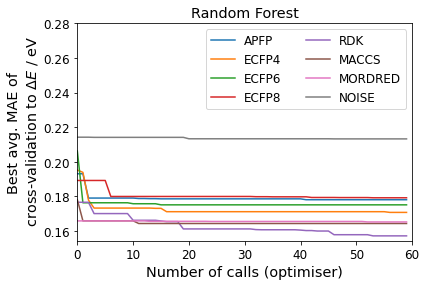

In [22]:
# For plotting
for fprint in fprint_type:
    this_running_errors = running_min_val(rf_error_values[fprint])
    plt.plot(this_running_errors,label=fprint)
plt.legend(loc='upper right',ncol=2,fontsize='large')
plt.tick_params(labelsize='large')
plt.xlim(left=0,right=60)
plt.ylim(top=0.28)
plt.xlabel('Number of calls (optimiser)',fontsize='x-large')
plt.ylabel('Best avg. MAE of\n cross-validation to $\Delta E$ / eV',fontsize='x-large')
plt.title('Random Forest',fontsize='x-large')
#plt.savefig('rf-optimisation.eps',bbox_inches='tight',dpi=600)
plt.show()

In [21]:
print('MAE and std. dev. on training data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,train_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_train))
for fprint in fprint_type:
    X_train = get_fingerprint(fprint,train_data,'train')[0] # get training data (preprocessed)
    # the best parameters are passed to get_model()
    predictor = get_model(rf_best_params[fprint],'rf',X_train,y_train,[],True) # get fitted model
    y_train_pred = predictor.predict(X_train)
    abs_max_pred = np.array(train_data.std_max_ev) + np.array(y_train_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(train_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(train_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on training data
----
Before fitting : MAE = 0.245 ; std. dev. = 0.264
APFP : MAE = 0.081 ; std. dev. = 0.109
ECFP4 : MAE = 0.072 ; std. dev. = 0.096
ECFP6 : MAE = 0.073 ; std. dev. = 0.097
ECFP8 : MAE = 0.081 ; std. dev. = 0.108
RDK : MAE = 0.072 ; std. dev. = 0.100
MACCS : MAE = 0.075 ; std. dev. = 0.101
MORDRED : MAE = 0.070 ; std. dev. = 0.093
NOISE : MAE = 0.174 ; std. dev. = 0.214


In [22]:
print('MAE and std. dev. on test data')
print('----')
print('Before fitting : MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,test_data.std_max_ev),end='')
print(' std. dev. = %.3f'%np.std(y_test))
for fprint in fprint_type:
    X_train, preproc = get_fingerprint(fprint,train_data,'train') # take fitted preprocessor for training data
    X_test = preproc.transform(get_fingerprint(fprint,test_data,'test',True)) # transform unmodified fingerprints
    predictor = get_model(rf_best_params[fprint],'rf',X_train,y_train,[],True) #get fitted model on training data
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    print(fprint,': MAE = %.3f ;'%mean_absolute_error(test_data.abs_max_ev,abs_max_pred),end='')
    print(' std. dev. = %.3f'%np.std(np.array(test_data.abs_max_ev)-abs_max_pred))

MAE and std. dev. on test data
----
Before fitting : MAE = 0.231 ; std. dev. = 0.263
APFP : MAE = 0.100 ; std. dev. = 0.135
ECFP4 : MAE = 0.084 ; std. dev. = 0.116
ECFP6 : MAE = 0.090 ; std. dev. = 0.124
ECFP8 : MAE = 0.097 ; std. dev. = 0.130
RDK : MAE = 0.087 ; std. dev. = 0.121
MACCS : MAE = 0.091 ; std. dev. = 0.128
MORDRED : MAE = 0.085 ; std. dev. = 0.120
NOISE : MAE = 0.214 ; std. dev. = 0.264


## Testing SVM/ECFP6 with training set size

The original training set contains 2500 samples (some of them are discarded during the initial sTD-xTB data collection). Here, we test whether removing some data from the training set reduces its efficiency on the testing set.

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, preproc = get_fingerprint('ECFP6',train_data,'train')
X_test = preproc.transform(get_fingerprint('ECFP6',test_data,'test',True))
X_train_part = X_train.copy()
y_train_part = y_train.copy()
MAE_with_loss = {} # dict to store MAE for number of training samples
for i in range(25):
    # we use the best hyperparameters from previous optimisation
    predictor = get_model(svm_best_params['ECFP6'],'svm',X_train_part,y_train_part,[],True) #get fitted model
    y_test_pred = predictor.predict(X_test)
    abs_max_pred = np.array(test_data.std_max_ev) + np.array(y_test_pred)
    MAE_with_loss[X_train_part.shape[0]] = mean_absolute_error(test_data.abs_max_ev,abs_max_pred)
    # lose 10% of the training dataset
    X_train_part, dummy0, y_train_part, dummy1 = train_test_split(X_train_part,y_train_part,test_size=0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


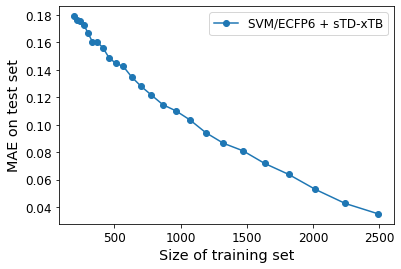

In [46]:
plt.plot(MAE_with_loss.keys(),MAE_with_loss.values(),'o-',label='SVM/ECFP6 + sTD-xTB')
plt.xlabel('Size of training set',fontsize='x-large')
plt.ylabel('MAE on test set',fontsize='x-large')
plt.tick_params(labelsize='large')
plt.legend(loc='upper right',fontsize='large')
#plt.savefig('SVM-ECFP6-loss-graph.eps',bbox_inches='tight',dpi=1000)
plt.show()

## Testing feature importance for SVM/ECFP6

When calculating feature importance, the fingerprint must not be put through PCA because the principal components are difficult to interpret. However, `VarianceThreshold()` and `StandardScaler()` will be used.

The parameters from the previous hyperparameter optimisation are used. This is because with high dimensionality data, there is a chance of overfitting, which will be exacerbated during hyperparameter optimisation.

In [17]:
from sklearn.inspection import permutation_importance

In [19]:
# check the hyperparameters for SVM with ECFP6
svm_best_params['ECFP6'].params

{'C_val': 1.4106487767732552,
 'gamma_val': 0.0004435641754358924,
 'epsilon_val': 0.0025527328245924384}

In [21]:
dummy_col_names = ['ECFP6 #'+str(x) for x in range(2048)]+[r'solvent $\varepsilon_\mathrm{opt}$',r'solvent $\varepsilon_\mathrm{r}$']
X_train = pd.DataFrame(get_fingerprint('ECFP6',train_data,'train',True)) #get unmodified ECFP6
preproc = Pipeline([('variance',VarianceThreshold()),('scaler',StandardScaler())])
X_train = preproc.fit_transform(X_train)
predictor = SVR(C=1.410648,gamma=0.00044356,epsilon=0.00255)
predictor.fit(X_train,y_train)
X_test = pd.DataFrame(get_fingerprint('ECFP6',test_data,'test',True)) # for test set
X_test = preproc.transform(X_test)

In [22]:
importances = permutation_importance(predictor,X_test,y_test,scoring='neg_mean_absolute_error',n_jobs=-1)

In [23]:
# save and reload
#with open('svm_ecfp6_importances.pkl','wb') as fh:
#    pickle.dump(importances,fh,pickle.HIGHEST_PROTOCOL)
#with open('svm_ecfp6_importances.pkl','rb') as fh:
#    importances = pickle.load(fh)

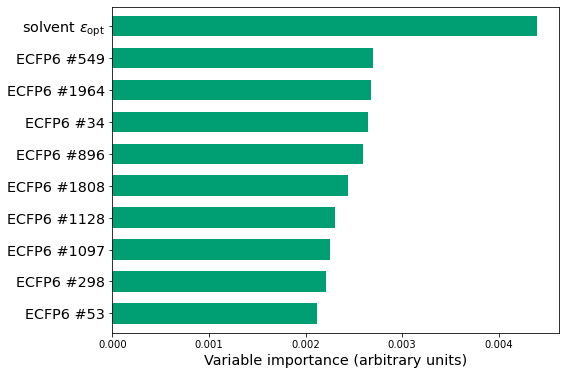

In [25]:
feat_names_preproc = preproc.get_feature_names_out(dummy_col_names)
sorted_feats_10 = importances.importances_mean.argsort()[-10:]
fig,ax = plt.subplots(figsize=(8,6))
ax.barh(
    feat_names_preproc[sorted_feats_10],
    importances.importances_mean[sorted_feats_10],
    height=0.64,
    color='#009E73')
ax.tick_params(which='major',axis='y',labelsize='x-large')
ax.set_xlabel('Variable importance (arbitrary units)',fontsize='x-large')
plt.margins(y=0.03)
#plt.savefig('SVM-ECFP6-feat-importance.png',dpi=600,bbox_inches='tight')
plt.show()

Now, the structures associated with top 5 important ECFP6 positions has to be determined. The positions of ECFP6 are \#34, \#496, \#1458, \#1964 and \#53.

In [27]:
# ECFP6 statistics
# get all the molecules
important_pos_list = [34,496,1458,1964,53]

mols_list = []
for mol_file in glob.iglob('./final_xtb_opt/*.mol'):
    mols_list.append(Chem.MolFromMolFile(mol_file))
for mol_file in glob.iglob('../test/final_xtb_opt/*.mol'):
    mols_list.append(Chem.MolFromMolFile(mol_file))
if None in mols_list:
    raise Exception('Error in reading mol files')
    
def push_smarts(list_smarts,input_smarts):
    if len(list_smarts) == 0:
        list_smarts.append(input_smarts)
        return None
    else:
        x1 = Chem.MolFromSmarts(input_smarts)
        flag = True
        for this_smarts in list_smarts:
            x2 = Chem.MolFromSmarts(this_smarts)
            if (x2.HasSubstructMatch(x1) and x1.HasSubstructMatch(x2)):
                flag = False
        if flag:
            list_smarts.append(input_smarts)
        return None

# iterate through molecules and generate stats
ecfp6_stats = {} # integer bit position : [list of SMARTS]
for mol in mols_list:
    bit_info = {}
    fp = GetHashedMorganFingerprint(mol,3,bitInfo=bit_info)
    for bit,info_tuples in bit_info.items(): # unpack bits
        if bit in important_pos_list:
            ecfp6_stats[bit] = list()
            for atomidx, radius in info_tuples: # unpack fp collision, if any
                dummy_mol = Chem.RWMol(mol) # dummy for editing
                atoms_inner = set()
                if radius == 0:
                    atoms_inner.add(atomidx)
                else:
                    env_inner = list(Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomidx))
                    for bondidx in env_inner:
                        atoms_inner.add(mol.GetBondWithIdx(bondidx).GetBeginAtomIdx())
                        atoms_inner.add(mol.GetBondWithIdx(bondidx).GetEndAtomIdx())
                env_outer = list(Chem.FindAtomEnvironmentOfRadiusN(mol,radius+1,atomidx))
                for bondidx in env_outer:
                    this_atomidx = mol.GetBondWithIdx(bondidx).GetBeginAtomIdx()
                    if this_atomidx not in atoms_inner:
                        dummy_mol.GetAtomWithIdx(this_atomidx).SetAtomicNum(0)
                    this_atomidx = mol.GetBondWithIdx(bondidx).GetEndAtomIdx()
                    if this_atomidx not in atoms_inner:
                        dummy_mol.GetAtomWithIdx(this_atomidx).SetAtomicNum(0)
                mol_frag = Chem.PathToSubmol(dummy_mol,env_outer)
                frag_smarts = Chem.MolToSmarts(mol_frag)
                push_smarts(ecfp6_stats[bit],frag_smarts)

In [28]:
ecfp6_stats

{34: ['[#6]-[#7](-[#6])-[#6]1:[#6]:[#6]:[#6](-[#0]):[#6]:[#6]:1'],
 1458: ['[#0]-[#6]1:[#6]:[#6]:[#6](-[#6]#[#6]-[#6](:[#0]):[#0]):[#6]:[#6]:1'],
 1964: ['[#0]1:[#6]:[#6]:[#6](-[#6](:[#6]:[#0]):[#6]:[#0]):[#6]:[#6]:1'],
 496: ['[#0]:[#6](-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:[#0]:[#6]:[#6]:2):[#7]:[#7]:1-[#6](:[#0]):[#0]):[#0]'],
 53: ['[#6]-[#6]1:[#6]:[#0]:[#8]:[#6]2:[#6]:[#6](-[#8]):[#6]:[#6]:[#6]:1:2']}

In [29]:
# print SMARTS in proper format
for bit, smarts_list in ecfp6_stats.items():
    print(bit,':',end=' ')
    for smarts in smarts_list:
        print(smarts.replace('[#0]','*'))

34 : [#6]-[#7](-[#6])-[#6]1:[#6]:[#6]:[#6](-*):[#6]:[#6]:1
1458 : *-[#6]1:[#6]:[#6]:[#6](-[#6]#[#6]-[#6](:*):*):[#6]:[#6]:1
1964 : *1:[#6]:[#6]:[#6](-[#6](:[#6]:*):[#6]:*):[#6]:[#6]:1
496 : *:[#6](-[#6]1:[#6]:[#6](-[#6]2:[#6]:[#6]:*:[#6]:[#6]:2):[#7]:[#7]:1-[#6](:*):*):*
53 : [#6]-[#6]1:[#6]:*:[#8]:[#6]2:[#6]:[#6](-[#8]):[#6]:[#6]:[#6]:1:2
